<a href="https://colab.research.google.com/github/benchov/AlgoTrading/blob/master/HMM_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyhhmm
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyhhmm: filename=pyhhmm-2.0.1-py3-none-any.whl size=35505 sha256=b2f5c4b071f17d61bf1a0735bff1c1cfdd7c611b7952fe0a95799e86729cbced
  Stored in directory: /root/.cache/pip/wheels/f5/06/8b/f56001a4de0010706182f4db98d045779a517011d47476708e
Successfully built pyhhmm
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.3 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyhhmm.gaussian import GaussianHMM
from pandas_datareader.data import DataReader

In [3]:
start_date = '2017-01-01'
end_date = '2022-06-01'
symbol = 'SPY'
data = DataReader(name=symbol, data_source='yahoo', start=start_date, end=end_date)
data = data[['Open', 'High', 'Low', 'Adj Close']]
data.head()

,Open,High,Low,Adj Close
Date,,,,
2017-01-03,225.039993,225.830002,223.880005,203.788040
2017-01-04,225.619995,226.750000,225.610001,205.000381
2017-01-05,226.270004,226.580002,225.479996,204.837585
2017-01-06,226.529999,227.750000,225.899994,205.570435
2017-01-09,226.910004,227.070007,226.419998,204.891891


In [4]:
df = data.copy()
df['Returns'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
df['Range'] = (df['High'] / df['Low']) - 1
df.dropna(inplace=True) 
df.head()

,Open,High,Low,Adj Close,Returns,Range
Date,,,,,,
2017-01-04,225.619995,226.750000,225.610001,205.000381,0.005949,0.005053
2017-01-05,226.270004,226.580002,225.479996,204.837585,-0.000794,0.004879
2017-01-06,226.529999,227.750000,225.899994,205.570435,0.003578,0.008189
2017-01-09,226.910004,227.070007,226.419998,204.891891,-0.003301,0.002871
2017-01-10,226.479996,227.449997,226.009995,204.891891,0.000000,0.006371


In [5]:
# add moving avarage
df['ma_12'] = df['Adj Close'].rolling(window=12).mean()
df['ma_21'] = df['Adj Close'].rolling(window=21).mean()

In [6]:
# create train and test dataset
X_train = df[['Returns', 'Range']].iloc[:500]
X_test = df[['Returns', 'Range']].iloc[500:]
df_save = df.iloc[500:]

print("Train Length: ", len(X_train))
print("Test Length: ", len(X_test))
print("X_train From: ", X_train.head(1).index.item())
print("X_train To: ", X_train.tail(1).index.item())
print("X_test From: ", X_test.head(1).index.item())
print("X_test To: ", X_test.tail(1).index.item())

Train Length:  500
Test Length:  862
X_train From:  2017-01-04 00:00:00
X_train To:  2018-12-28 00:00:00
X_test From:  2018-12-31 00:00:00
X_test To:  2022-06-01 00:00:00


In [7]:
# create model
model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=2)

# train model
model.train([np.array(X_train.values)])

# test model prediction capability on train dataset
model.predict([X_train.values])[0][:10]


array([1, 1, 1, 1, 0, 1, 0, 1, 0, 1], dtype=int32)

In [8]:
df_main = df_save.copy()

hmm_result = model.predict([np.array(X_test.values)])
df_main['HMM'] = hmm_result[0]
df_main.head()

,Open,High,Low,Adj Close,Returns,Range,ma_12,ma_21,HMM
Date,,,,,,,,,
2018-12-31,249.559998,250.190002,247.470001,234.892059,0.008759,0.010991,234.400194,241.900978,1
2019-01-02,245.979996,251.210007,245.949997,235.136444,0.001040,0.021387,233.331146,240.906982,2
2019-01-03,248.229996,248.570007,243.669998,229.525421,-0.023863,0.020109,232.176064,239.571488,2
2019-01-04,247.589996,253.110001,247.169998,237.213547,0.033496,0.024032,232.059563,238.439681,2
2019-01-07,252.690002,255.949997,251.690002,239.083893,0.007885,0.016926,232.120726,237.799630,0


In [9]:
# add Moving Avarage Signals to the dataset
df_main.loc[df['ma_12'] > df['ma_21'], 'ma_signal'] = 1
df_main.loc[df['ma_12'] <= df['ma_21'], 'ma_signal'] = 0

In [10]:
# create HMM signal and add to dataset
signal_states = [0,1]
hmm_states = df_main['HMM'].values
hmm_signals = [1 if x in signal_states else 0 for x in hmm_states]
df_main['hmm_signal'] = hmm_signals
df_main.head()

,Open,High,Low,Adj Close,Returns,Range,ma_12,ma_21,HMM,ma_signal,hmm_signal
Date,,,,,,,,,,,
2018-12-31,249.559998,250.190002,247.470001,234.892059,0.008759,0.010991,234.400194,241.900978,1,0.0,1
2019-01-02,245.979996,251.210007,245.949997,235.136444,0.001040,0.021387,233.331146,240.906982,2,0.0,0
2019-01-03,248.229996,248.570007,243.669998,229.525421,-0.023863,0.020109,232.176064,239.571488,2,0.0,0
2019-01-04,247.589996,253.110001,247.169998,237.213547,0.033496,0.024032,232.059563,238.439681,2,0.0,0
2019-01-07,252.690002,255.949997,251.690002,239.083893,0.007885,0.016926,232.120726,237.799630,0,0.0,1


In [11]:
# creating combined signal from Ma and HMM
df_main['main_signal'] = 0
df_main.loc[(df_main['ma_signal'] == 1) & (df_main['hmm_signal'] == 1), 'main_signal'] = 1
df_main['main_signal'] = df_main['main_signal'].shift(1)

In [12]:
# benchmark returns
df_main['bench_return'] = np.log(df_main['Adj Close'] / df_main['Adj Close'].shift(1))
df_main['bench_sum'] = df_main['bench_return'].cumsum()
df_main['bench_exp_ret'] = np.exp(df_main['bench_sum']) -1

In [14]:
# strategy returns
df_main['strategy_return'] = np.log(df_main['Open'].shift(-1) / df_main['Open']) * df_main['main_signal']
df_main['strategy_sum'] = df_main['strategy_return'].cumsum()
df_main['strategy_exp_ret'] = np.exp(df_main["strategy_sum"]) - 1

In [16]:
df_main.dropna(inplace=True)
df_main.tail()

,Open,High,Low,Adj Close,Returns,Range,ma_12,ma_21,HMM,ma_signal,hmm_signal,main_signal,bench_return,bench_sum,bench_exp_ret,strategy_return,strategy_sum,strategy_exp_ret
Date,,,,,,,,,,,,,,,,,,
2022-05-24,392.559998,395.149994,386.959991,390.591339,-0.007634,0.021165,392.868772,401.961978,2,0.0,0,0.0,-0.007663,0.508536,0.662855,-0.0,0.421369,0.524047
2022-05-25,392.309998,399.450012,391.890015,394.042206,0.008835,0.019291,392.802663,401.077542,2,0.0,0,0.0,0.008796,0.517332,0.677546,0.0,0.421369,0.524047
2022-05-26,398.670013,407.040009,398.450012,401.915710,0.019981,0.021559,393.316655,400.512788,2,0.0,0,0.0,0.019784,0.537116,0.711066,0.0,0.421369,0.524047
2022-05-27,407.910004,415.380005,407.700012,411.782379,0.024549,0.018837,395.176781,399.920175,2,0.0,0,0.0,0.024253,0.561369,0.753071,0.0,0.421369,0.524047
2022-05-31,413.549988,416.459991,410.029999,409.471893,-0.005611,0.015682,396.878245,399.964090,2,0.0,0,0.0,-0.005627,0.555742,0.743234,0.0,0.421369,0.524047


In [17]:
# calculating sharp ratio 
def sharpe_ratio(returns_series):
  N = 255
  NSQRT = np.sqrt(N)
  rf = 0.01
  mean = returns_series.mean() * N
  sigma = returns_series.std() * NSQRT
  sharpe_ratio = round((mean - rf) / sigma, 2)
  return sharpe_ratio

In [18]:
# Metrics
bench_rets = round(df_main["bench_exp_ret"].values[-1] * 100, 1)
strat_rets = round(df_main["strategy_exp_ret"].values[-1] * 100, 1)

bench_sharpe = sharpe_ratio(df_main["bench_return"].values)
strat_sharpe = sharpe_ratio(df_main["strategy_return"].values)

In [19]:
# Print Metrics
print(f"Returns Benchmark: {bench_rets}%")
print(f"Returns Strategy: {strat_rets}%")
print("---- ---- ---- ---- ---- ----")
print(f"Sharpe Benchmark: {bench_sharpe}")
print(f"Sharpe Strategy: {strat_sharpe}")

Returns Benchmark: 74.3%
Returns Strategy: 52.4%
---- ---- ---- ---- ---- ----
Sharpe Benchmark: 0.69
Sharpe Strategy: 1.27


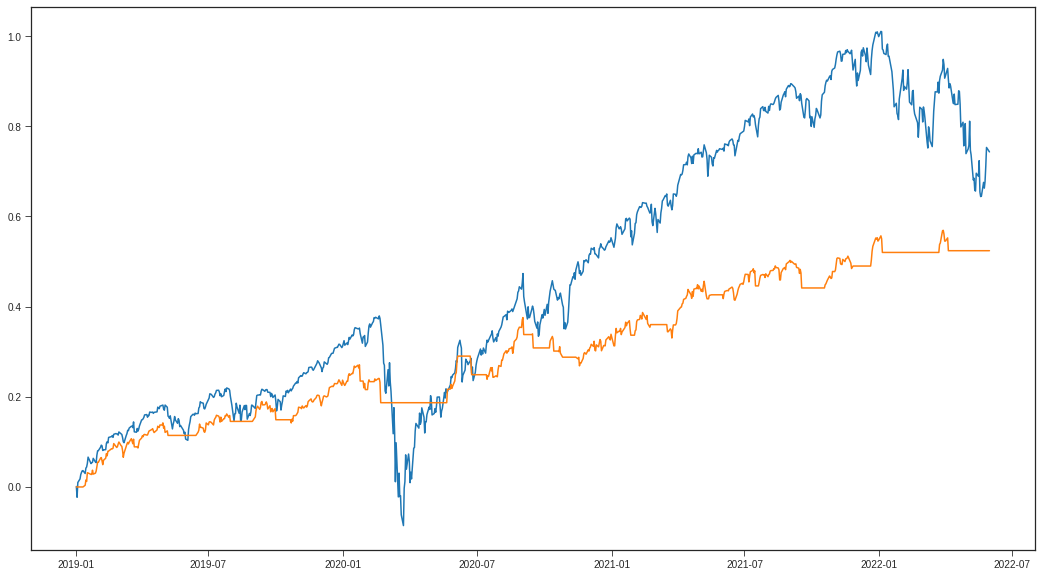

In [20]:
# plotting results
# Plot Equity Curves
fig = plt.figure(figsize = (18, 10))
plt.plot(df_main["bench_exp_ret"])
plt.plot(df_main["strategy_exp_ret"])
plt.show()

In [22]:
# Save Data
df_main.to_csv("/HMM-SPY.csv")